<a href="https://colab.research.google.com/github/Ayush8795/video_classification/blob/main/cnn_lstm_video_pred2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
from moviepy.editor import *
%matplotlib inline
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
file_path= '/content/drive/MyDrive/IsroDataset'

Cell to look data

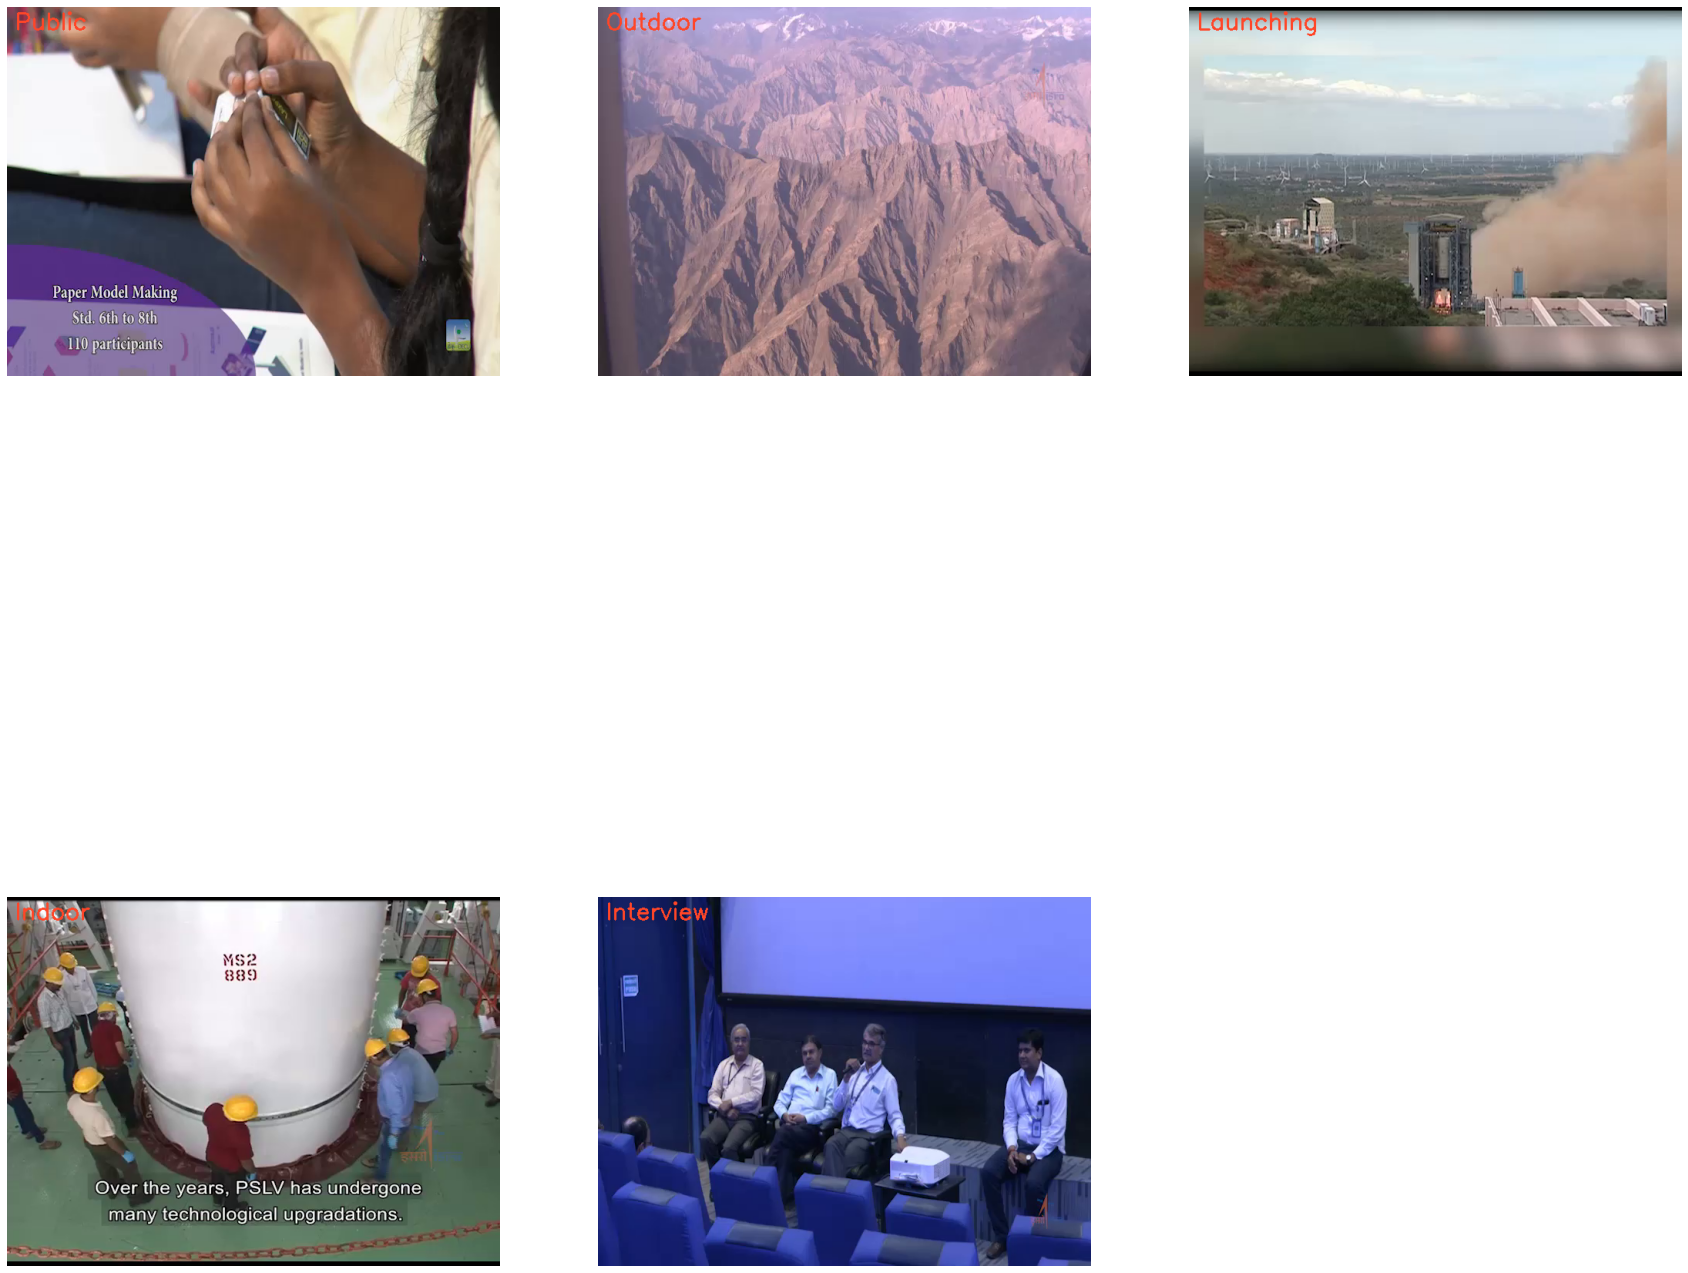

In [ ]:
plt.figure(figsize = (30, 30))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(file_path)
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = range(len(all_classes_names))
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{file_path}/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{file_path}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 70, 40), 2)
    
    # Display the frame.
    plt.subplot(2, 3, counter);
    plt.imshow(rgb_frame);
    plt.axis('off')
    #print(counter)

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
SEQUENCE_LENGTH = 20

CLASSES_LIST = ["Public", "Outdoor", "Launching", "Indoor", "Interview"]

DATASET_DIR = file_path

In [ ]:
def frames_extraction(video_path):
    
 
    #List to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            
            # Ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Public
Extracting Data of Class: Outdoor
Extracting Data of Class: Launching
Extracting Data of Class: Indoor
Extracting Data of Class: Interview


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
print(one_hot_encoded_labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [ ]:
features_train,features_test,labels_train,labels_test= train_test_split(features,one_hot_encoded_labels,
                                                                        shuffle= True,
                                                                        test_size=0.25,random_state= seed_constant)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

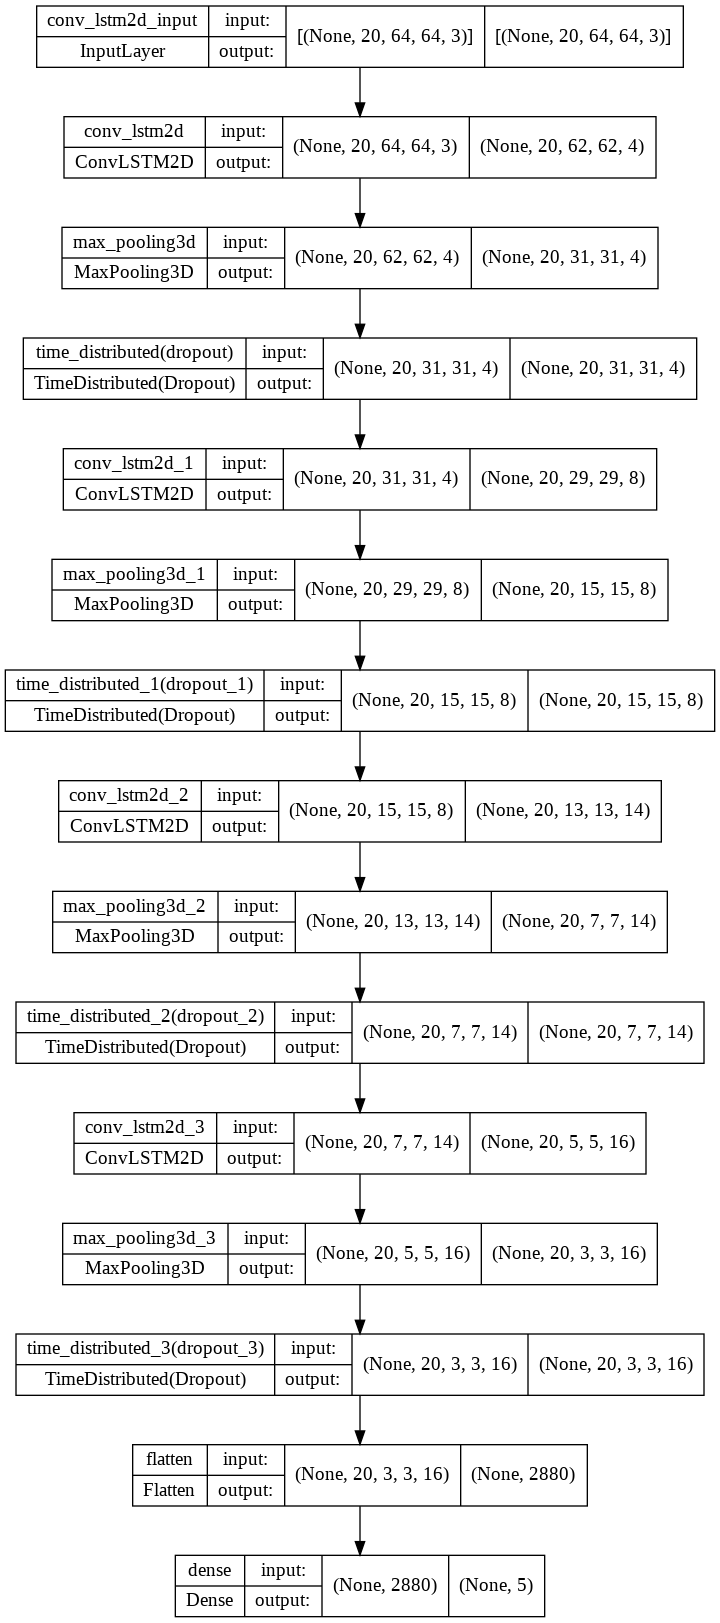

In [ ]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)


In [ ]:
early_stopping_callback= EarlyStopping(monitor= 'val_loss', patience= 10, mode= 'min', restore_best_weights= True)

In [ ]:
from gc import callbacks
convlstm_model.compile(loss= 'categorical_crossentropy', optimizer= 'Adam', metrics= ['accuracy'])
convlstm_model_history= convlstm_model.fit(x= features_train, y= labels_train, epochs= 50, batch_size= 4,
                                           shuffle= True, validation_split= 0.2,
                                           callbacks= [early_stopping_callback])                                           

Epoch 1/50
256/256 [==============================] - 513s 2s/step - loss: 1.4028 - accuracy: 0.4110 - val_loss: 1.2297 - val_accuracy: 0.4766
Epoch 2/50
256/256 [==============================] - 496s 2s/step - loss: 1.2749 - accuracy: 0.4765 - val_loss: 1.2250 - val_accuracy: 0.5000
Epoch 3/50
256/256 [==============================] - 494s 2s/step - loss: 1.1989 - accuracy: 0.4941 - val_loss: 1.1776 - val_accuracy: 0.5742
Epoch 4/50
256/256 [==============================] - 494s 2s/step - loss: 1.1310 - accuracy: 0.5470 - val_loss: 1.0541 - val_accuracy: 0.5703
Epoch 5/50
256/256 [==============================] - 504s 2s/step - loss: 1.0005 - accuracy: 0.5939 - val_loss: 1.0656 - val_accuracy: 0.6133
Epoch 6/50
256/256 [==============================] - 500s 2s/step - loss: 0.9355 - accuracy: 0.6380 - val_loss: 1.0297 - val_accuracy: 0.6133
Epoch 7/50
256/256 [==============================] - 499s 2s/step - loss: 0.8283 - accuracy: 0.6810 - val_loss: 0.9508 - val_accuracy: 0.6328

In [ ]:
model_evaluation_history= convlstm_model.evaluate(features_test,labels_test)

14/14 [==============================] - 50s 3s/step - loss: 1.0447 - accuracy: 0.6033


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'VidClassCNN_LSTM{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_history, metric1, metric2, plot_name):
  metric_value1= model_history.history[metric1]
  metric_value2= model_history.history[metric2]
  epochs= range(len(metric_value1))

  plt.plot(epochs, metric_value1, 'blue', label= metric1)
  plt.plot(epochs, metric_value2, 'red', label= metric2)

  plt.title(str(plot_name))

  plt.legend()


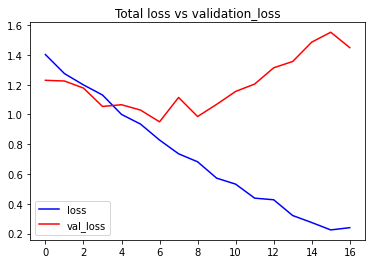

In [ ]:
plot_metric(convlstm_model_history,'loss','val_loss','Total loss vs validation_loss')

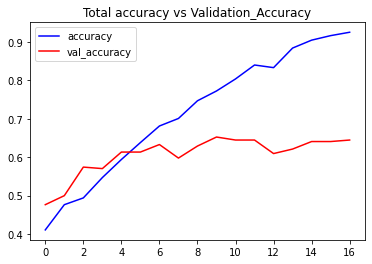

In [ ]:
plot_metric(convlstm_model_history, 'accuracy','val_accuracy','Total accuracy vs Validation_Accuracy')

In [ ]:
import os
import cv2
#import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
model= tf.keras.models.load_model('/content/VidClassCNN_LSTM2022_08_20__19_35_13___Loss_1.044716715812683___Accuracy_0.6032863855361938.h5')

In [ ]:
video_file_path= '/content/test_video.mp4'

In [ ]:
#mean= np.array([123.68,116.779,103.939][::1],dtype="float32")
Queue= deque(maxlen=130)
outputvideo= '/content/output_folder/tested_video.mp4'

THRESH_HOLD= 0.4
prob_arr= []
labels= []

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
SEQUENCE_LENGTH = 20

CLASSES_LIST = ["Public", "Outdoor", "Launching", "Indoor", "Interview"]


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
video_cap= cv2.VideoCapture(video_file_path)
vid_width= int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
vid_height= int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

video_writer = cv2.VideoWriter(outputvideo, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_cap.get(cv2.CAP_PROP_FPS), (vid_width,vid_height))

frames_queue = deque(maxlen = SEQUENCE_LENGTH)



#frames_list= []
pred_classes= ''
pred_prob= []
video_frames_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
skip_frames= max(int(video_frames_count/SEQUENCE_LENGTH),1)

while video_cap.isOpened():
  
  video_cap.set(cv2.CAP_PROP_POS_FRAMES,frame_counter*skip_frames)
  success,frame= video_cap.read()

  if not success:
    print('Video Read Error')
    break;
  
  resized_frame= cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
  normalized_frame= resized_frame/255
  frames_queue.append(normalized_frame)

  if len(frames_queue)==SEQUENCE_LENGTH:
    pred_prob= model.predict(np.expand_dims(frames_queue,axis=0))[0]
    #for i,prob in enumerate(pred_prob):
      #if prob>=THRESH_HOLD:
        #np.append(pred_prob,prob)
        #pred_classes= pred_classes+' '+CLASSES_LIST[i]
        
    pred_label= np.argmax(pred_prob)
    pred_classes= CLASSES_LIST[pred_label]  
    print(pred_label,' ',pred_classes)
    
  #text= 'Video: {pred_classes}'
  #cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
  #video_writer.write(frame)
  #cv2_imshow(frame)
  #key= cv2.waitKey(1)& 0xFF

  #if key== ord("q"):
    #break


video_cap.release()
video_writer.release()

print('Execution over')


In [ ]:
mean= np.array([123.68,116.779,103.939][::1],dtype="float32")
mean= mean/255
Queue= deque(maxlen=SEQUENCE_LENGTH)
pred_prob_q= deque(maxlen= 130)

In [ ]:
capture_video= cv2.VideoCapture(video_file_path)
writer= None
(Width, Height)= (None,None)

while True:
  (taken,frame)= capture_video.read()
  if not taken:
    break
  if Width is None or Height is None:
    (Width,Height)= frame.shape[:2]
  #print(frame.shape)
  output= frame.copy()
  frame= cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  frame= cv2.resize(frame, (IMAGE_WIDTH,IMAGE_HEIGHT))
  frame= frame/255
  frame= frame.astype("float32")
  #print(frame.shape)
  #frame= frame.astype("float32")
  frame-= mean
  Queue.append(frame)
  #frame= frame.reshape(-1,20,64,64,3)
  if len(Queue)==SEQUENCE_LENGTH:
    preds= model.predict(np.expand_dims(Queue,axis=0))[0]
    pred_prob_q.append(preds)
    results= np.array(pred_prob_q).mean(axis= 0)
  #for i in results:
    #if i>=THRESH_HOLD :
      #labels.append(CLASSES_LIST[i])
    i= np.argmax(results)
    label= CLASSES_LIST[i]
    text= "Video: {}".format(label)
    cv2.putText(output,text, (45,60),cv2.FONT_HERSHEY_SIMPLEX,1.25,(0,0,0),thickness= 3)

    if writer is None:
      fourcc= cv2.VideoWriter_fourcc(*"MJPG")
      writer= cv2.VideoWriter(outputvideo,fourcc,30,(Width, Height),True)
    
    writer.write(output)
    cv2_imshow(output)
    key= cv2.waitKey(1)& 0xFF

    if key== ord("q"):
      break

print("Finalizing...")
writer.release()
capture_video.release()

/usr/local/lib/python3.7/dist-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


ValueError: ignored